# Initialization

## Import of useful modules:

In [1]:
%matplotlib inline
import os, sys
import matplotlib.pyplot as plt
import numpy as np
from pprint import pprint
from tqdm.notebook import tqdm

from time import sleep, monotonic, time


import qcodes as qc
from qcodes import Parameter
from qcodes.dataset.plotting import plot_dataset, plot_by_id
from qcodes.utils.metadata import diff_param_values
from qcodes.instrument.specialized_parameters import ElapsedTimeParameter
from qcodes.dataset.measurements import Measurement

# sys.path.append('M:\\tnw\\ns\\qt\\2D Topo\\code\\qcodes')
sys.path.append('C:\\qcodes')
from sweeps import do1d, do2d, time_sweep, measure_until, do1d_until

import warnings
warnings.filterwarnings('ignore')

In [2]:
fridge_name = 'BF1'
# %run ..\..\..\..\..\code\qcodes\init_fridge.py {fridge_name}
%run C:\\qcodes\init_fridge.py {fridge_name}
# %run ..\init_fridge.py {fridge_name}

Connected to: KEITHLEY INSTRUMENTS DMM6500 (serial:04518052, firmware:1.7.7b) in 0.72s
Connected to: Stanford_Research_Systems SR860 (serial:004608, firmware:V1.51) in 0.04s


Zero dacs and lockin

In [3]:
lockin_1.amplitude(0e-8)
lockin_1.sine_outdc(0e-5)
lockin_1_amplitude = lockin_1.amplitude()
lockin_1_sine_outdc = lockin_1.sine_outdc()
lockin_1_sensitivity = lockin_1.sensitivity()
print(f"Lockin_1 amplitude {lockin_1_amplitude} Amp.")
print(f"Lockin_1 sine AC RMS {lockin_1_sine_outdc} Amp.")
print(f"Lockin_1 sensitivity {lockin_1_sensitivity} Amp.")


Lockin_1 amplitude 0.0 Amp.
Lockin_1 sine AC RMS 0.0 Amp.
Lockin_1 sensitivity 0.01 Amp.


In [3]:
# ivvi.set_dacs_zero()
lockin_1.amplitude(0)
lockin_1.sine_outdc(0)

In [ ]:
step=10
for i in range (step):
    print(keithley_2.amplitude())
    sleep(1)

In [ ]:
K213.voltage1(0)
# K213.voltage2(0)
# K213.voltage3(0.1)
# K213.voltage4(0.1)
# snapshot_of_station = station.snapshot()
# pprint(snapshot_of_station)

In [ ]:
station.snapshot(update=True);

In [ ]:
snapshot_of_station = station.snapshot()
print(snapshot_of_station)

In [ ]:
keithley_24.output(1)
keithley_24.rangev(42)
keithley_24.volt(0)
# keithley_24.output(0)
# sleep(1)
v_read=keithley_2.amplitude()
print(v_read)

## DAC rates

In [ ]:
# ivvi.dac1.step = 50
# ivvi.dac1.inter_delay = 0.05
# ivvi.dac2.step = 50
# ivvi.dac2.inter_delay = 0.05
# ivvi.dac3.step = 1
# ivvi.dac3.inter_delay = 0.2

## Database initialisation

Next, we create a qcodes database. If you want to use an existing one, set reuse 'True'. Database is created in the "data" folder. Sample folder is the same as for this script

In [4]:
reuse = False
%run C:\\qcodes\init_database.py {reuse}

Creating a new database file:
c:\qcodes\personal_scripts\data\qcodes_personal_scripts_2024-05-10_01.db



# Scaled parameters

It is more convenient to use meaningful parameters with correct units

In [5]:
from qcodes import ManualParameter, ScaledParameter

## Defining scaled parameters

In [6]:
Irange = Parameter('Irange', label='current range', unit='', set_cmd=None, get_cmd=None)
Vrange = Parameter('Vrange', label='voltage range', unit='', set_cmd=None, get_cmd=None)
TGrange = Parameter('TGrange', label='Top gate range', unit='', set_cmd=None, get_cmd=None)

#division paraemtrs required for simplier update: they used as an argument for scaled paraemtrs of sorce instruments

Irange_division = Parameter('Irange_division', 
                            label='scaled current range', unit='', 
                            set_cmd=None, get_cmd=lambda : 1 / Irange())

Vrange_division = Parameter('Vrange_division', 
                            label='scaled voltage range', unit='', 
                            set_cmd=None, get_cmd=lambda : 1 / Vrange())

TGrange_division = Parameter('TGrange_division', 
                             label='scaled Top gate range', unit='', 
                             set_cmd=None, get_cmd=lambda : 1/ TGrange())

Irange_AC_division = Parameter('Irange_AC_division', 
                               label='scaled current range for lockin', unit='', 
                               set_cmd=None, get_cmd=lambda : 1 / Irange())

Vrange_AC_division = Parameter('Vrange_AC_division', 
                               label='scaled voltage range for lockin', unit='', 
                               set_cmd=None, get_cmd=lambda : 1 / Vrange())

Gain_K1 = Parameter('Gain_K1', label='Gain K1', unit='', set_cmd=None, get_cmd=None)
Gain_K2 = Parameter('Gain_K2', label='Gain K2', unit='', set_cmd=None, get_cmd=None)
Gain_L1 = Parameter('Gain_L1', label='Gain L1', unit='', set_cmd=None, get_cmd=None)
Gain_L2 = Parameter('Gain_L2', label='Gain L2', unit='', set_cmd=None, get_cmd=None)

#Add components
station.add_component(Irange)
station.add_component(Vrange)
station.add_component(TGrange)

station.add_component(Irange_division)
station.add_component(Vrange_division)
station.add_component(TGrange_division)

station.add_component(Irange_AC_division)
station.add_component(Vrange_AC_division)
                             
station.add_component(Gain_K1)
station.add_component(Gain_K2)
station.add_component(Gain_L1)
station.add_component(Gain_L2)

'Gain_L2'

## IVVI rack parameters - update here during measuerements

In [7]:
Irange.set(1e-6)
Vrange.set(10e-3)
TGrange.set(15)
Gain_K1.set(1e2)
Gain_K2.set(1e2)
# Gain_K3.set(1e2)
Gain_L1.set(Gain_K1())
Gain_L2.set(Gain_K2())
#division parameters are updated automatically

## DC parameters
Check that devicies are correct!

In [8]:
# appl_current = ScaledParameter(ivvi.dac1, division = Irange_division, name = 'appl_current', unit = 'A')
appl_current = ScaledParameter(lockin_1.sine_outdc, division = Irange_division, name = 'appl_current', unit = 'A')
appl_voltage = ScaledParameter(lockin_1.sine_outdc, division = Vrange_division, name = 'appl_voltage', unit = 'V')
# appl_TG = ScaledParameter(ivvi.dac3, division = TGrange_division, name = 'appl_TG', unit = 'V')

meas_voltage_K1 = ScaledParameter(keithley1.amplitude, division = Gain_K1, name = 'meas_voltage_K1', unit = 'V')
# meas_voltage_K2 = ScaledParameter(keithley_2.amplitude, division = Gain_K2, name = 'meas_voltage_K2', unit = 'V')

# meas_leakage = ScaledParameter(keithley_2.amplitude, division = Gain_K2, name = 'meas_leakage', unit = 'A')

meas_current_K1 = ScaledParameter(keithley1.amplitude, division = Gain_K1, name = 'meas_current_K1', unit = 'A')
# meas_current_K2 = ScaledParameter(keithley_2.amplitude, division = Gain_K2, name = 'meas_current_K2', unit = 'A')

station.add_component(appl_current)
station.add_component(appl_voltage)
# station.add_component(appl_TG)
station.add_component(meas_voltage_K1)
# station.add_component(meas_voltage_K2)
# station.add_component(meas_leakage)
station.add_component(meas_current_K1)
# station.add_component(meas_current_K2)

'meas_current_K1'

## AC parameters

In [9]:
appl_current_AC = ScaledParameter(lockin_1.amplitude, 
                                  division = Irange_AC_division, name = 'appl_current_AC', unit = 'A')

appl_voltage_AC = ScaledParameter(lockin_1.amplitude, 
                                  division = Vrange_AC_division, name = 'appl_voltage_AC', unit = 'V')

station.add_component(appl_current_AC)
station.add_component(appl_voltage_AC)

meas_voltage_AC_L1 = ScaledParameter(lockin_1.X, division = Gain_L1, name = 'meas_voltage_Lockin1', unit = 'V')
meas_current_AC_L1 = ScaledParameter(lockin_1.X, division = Gain_L1, name = 'meas_current_Lockin1', unit = 'A')

# meas_voltage_AC_L2 = ScaledParameter(lockin_2.X, division = Gain_L2, name = 'meas_voltage_Lockin2', unit = 'V')
# meas_current_AC_L2 = ScaledParameter(lockin_2.X, division = Gain_L2, name = 'meas_current_Lockin2', unit = 'A')

station.add_component(meas_voltage_AC_L1)
station.add_component(meas_current_AC_L1)

# station.add_component(meas_voltage_AC_L2)
# station.add_component(meas_current_AC_L2)

meas_voltage_AC_L1_R = ScaledParameter(lockin_1.R, division = Gain_L1, name = 'meas_voltage_R_Lockin1', unit = 'V')
# meas_voltage_AC_L2_R = ScaledParameter(lockin_2.R, division = Gain_L2, name = 'meas_voltage_R_Lockin2', unit = 'V')

station.add_component(meas_voltage_AC_L1_R)
# station.add_component(meas_voltage_AC_L2_R)

'meas_voltage_R_Lockin1'

## Another useful example: magnet using dac (Janis)

>2231.2 G per A => 0.22312 T per A<br>
I source 10mA per V => 1e-5 A per 1mV<br>
result: 0.22312 T/A * 1e-5 A/mV

In [ ]:
#check Janis and VectorJanis!
#magnetic_field = ScaledParameter(ivvi.dac3, gain = 0.22312e-5, name = 'magnetic_field_dac', unit = 'T')
#station.add_component(magnetic_field)

In [10]:
def get_R_from_IV(dataid):
    dataset = qc.load_by_id(dataid)

    voltage = dataset.get_parameter_data()['meas_voltage_K1']['meas_voltage_K1']
    current = dataset.get_parameter_data()['meas_voltage_K1']['appl_current']
    fit_values = np.polyfit(current,voltage,1)
    
    return fit_values[0]

def get_R_from_IV_2(dataid):
    dataset = qc.load_by_id(dataid)

    voltage = dataset.get_parameter_data()['meas_voltage_K2']['meas_voltage_K2']
    current = dataset.get_parameter_data()['meas_voltage_K2']['appl_current']
    fit_values = np.polyfit(current,voltage,1)
    
    return fit_values[0]

# Fridge

# Parameter to get R from fast IV

In [ ]:
I_lim_r_IV = 5e-9
N_point_r_IV = 40
delay_r_IV = 0.02

In [11]:
R_val_2 = None

def get_R_from_IV_1():
    global R_val_2
    I_vals = np.linspace(-I_lim_r_IV, I_lim_r_IV, N_point_r_IV)
    V_vals_1 = np.zeros_like(I_vals)
    V_vals_2 = np.zeros_like(I_vals)
    appl_current.post_delay = delay_r_IV
    
    for i, I_val in enumerate(I_vals):
        appl_current(I_val)
        V_vals_1[i] = meas_voltage_K1()
        V_vals_2[i] = meas_voltage_K2()
        
    fit_values_1 = np.polyfit(I_vals,V_vals_1,1)
    fit_values_2 = np.polyfit(I_vals,V_vals_2,1)
    
    R_val_2 = fit_values_2[0]
    
    return fit_values_1[0]

def get_R_from_IV_2():
    global R_val_2
    if R_val_2:
        last_val = R_val_2
        R_val_2 = None
    else:
        get_R_from_IV_1()
        last_val = R_val_2
        R_val_2 = None
    
    return last_val

In [49]:
import time
start_time = time.time()
get_R_from_IV_1()
print("--- %s seconds ---" % (time.time() - start_time))

NameError: name 'I_lim_r_IV' is not defined

In [48]:
r_from_IV_1 = Parameter('r_from_IV_1', 
                       label='resistance from fast IV K1 fit', unit='Ohm', 
                       set_cmd=None, get_cmd=get_R_from_IV_1)

r_from_IV_2 = Parameter('r_from_IV_2', 
                       label='resistance from fast IV K2 fit', unit='Ohm', 
                       set_cmd=None, get_cmd=get_R_from_IV_2)

# Simple IVs

In [24]:
lockin_1.sensitivity(0.001)

In [44]:
lockin_1.sensitivity(1)

In [108]:
appl_current(0.11e-6)

In [96]:
appl_current(0)

In [97]:
appl_current_AC(0e-9)

In [90]:
lockin_1.auto_range()

In [72]:
lockin_1.input_range()

0.3

In [102]:
meas_voltage_K1()

-1.883852e-05

There is (are) already experiment(s) with the name of IV and sample name of Dio03_26_27_19_19 Ohms in the database.


Starting experimental run with id: 9. 


  0%|          | 0/101 [00:00<?, ?it/s]

Trying to mark a run completed that was already completed.


Lockin_1 sensitivity 0.01 Volt.
R = 2098.130691327898 Ohms


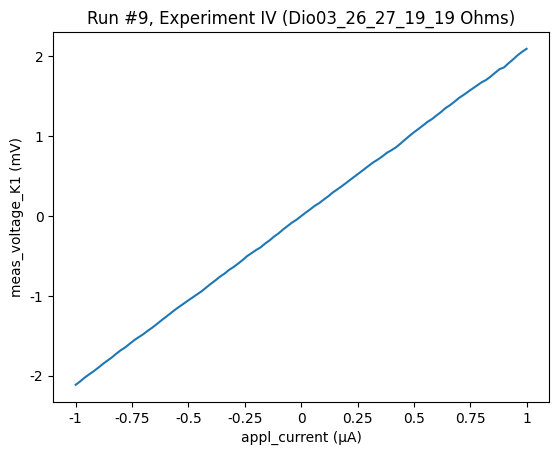

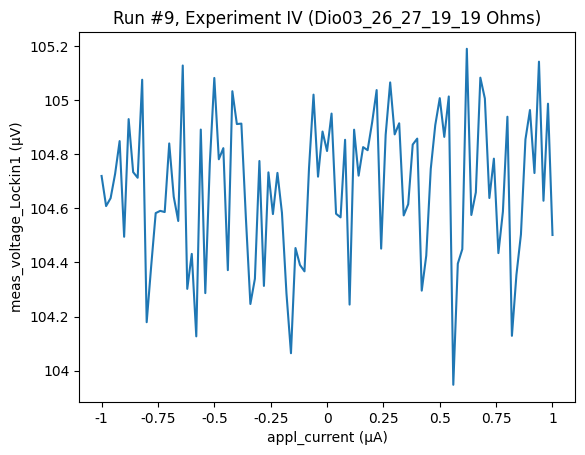

In [20]:
# sleep(10)
current_range = 1e-6
lockin_1_sensitivity = lockin_1.sensitivity()
appl_current(-current_range)
appl_current_AC(50e-9)
sleep(2)
station.snapshot(update=True);
exp = qc.new_experiment('IV', sample_name=f'Dio03_26_27_19_19 Ohms')
dataid = do1d(appl_current, -current_range, current_range, 101, 0.1,  meas_voltage_K1, meas_voltage_AC_L1)
# ivvi.set_dacs_zero()
appl_current(0)
appl_current_AC(0)
plot_by_id(dataid)
print(f"Lockin_1 sensitivity {lockin_1_sensitivity} Volt.")
print(f"R = {get_R_from_IV(dataid)} Ohms")
# print(get_R_from_IV_2(dataid))

Trying to mark a run completed that was already completed.


1049.8759882923705


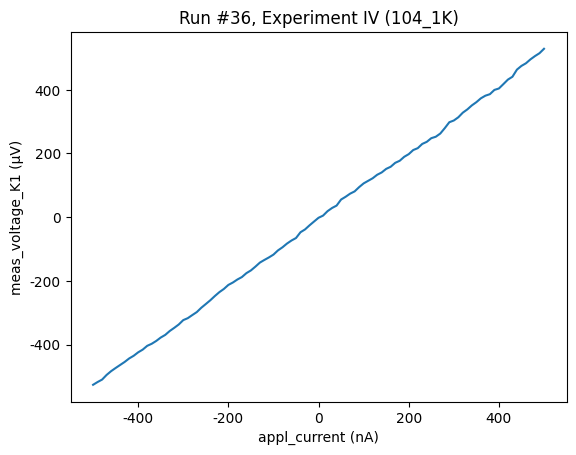

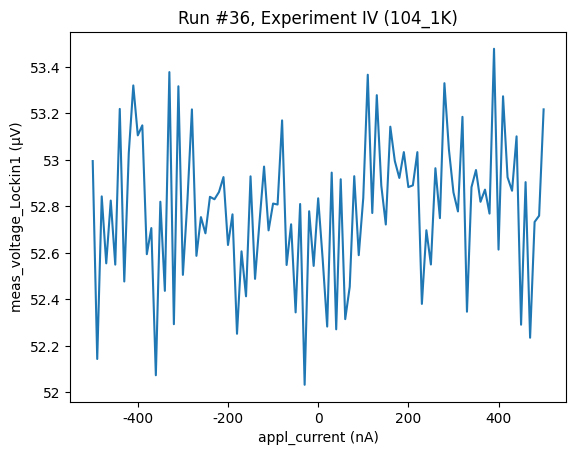

In [109]:
id = 36
plot_by_id(id)
print(get_R_from_IV(id))

In [14]:
lockin_1.auto_range
lockin_1.auto_scale

In [41]:
print(get_R_from_IV(dataid))
# print(get_R_from_IV_2(dataid))

954.2877751892828


In [ ]:
appl_current_AC(10e-9)
appl_current(-1e-6)
sleep(10)
station.snapshot(update=True);
exp = qc.new_experiment('IV + AC', sample_name='TL1_fL_finger')
dataid = do1d(appl_current, -1e-6, 1e-6, 501, 3, 
              meas_voltage_K1, meas_voltage_AC_L1, lockin_1.P, 
              meas_voltage_K2, meas_voltage_AC_L2, lockin_2.P)
# plot_by_id(dataid)
ivvi.set_dacs_zero()
lockin_1.amplitude(0.004)

# Zero Everything

In [21]:
appl_current(0e-6)
appl_current_AC(0e-6)
lockin_1.amplitude()
lockin_1.sine_outdc()

# ivvi.print_readable_snapshot(update=True)

SyntaxError: invalid syntax (624518687.py, line 4)

# Gate simple sweeps

In [ ]:
exp = qc.new_experiment('I_vs_Vtg', sample_name='BL1')

appl_voltage(1e-3)

start_gate = 0.0
stop_gate = 0.45
num_points = 500
leak_threshold = 1e-9

#Register independent parameters
meas = Measurement()
meas.register_parameter(appl_TG)
appl_TG.post_delay = 0.05

#Register dependent parametrs
param_meas = [meas_current_K1, meas_leakage]
output = []
for parameter in param_meas:
    meas.register_parameter(parameter, setpoints=(appl_TG,))
    output.append([parameter, None])

#Add action at the end
meas.add_after_run(ivvi.set_dacs_zero, ())

appl_TG(start_gate)
sleep(2)

#Start measuremnts
with meas.run() as datasaver:
    for set_point in tqdm(np.linspace(start_gate, stop_gate, num_points)):
        appl_TG(set_point)
        sleep(0.05)
        if np.abs(meas_leakage()) > leak_threshold:
            print('Leakage detected!')
            break
        sleep(0.05)
        for i, parameter in enumerate(param_meas):
            output[i][1] = parameter.get()
        datasaver.add_result((appl_TG, appl_TG()),
                             *output)
dataid = datasaver.run_id  # convenient to have for plotting

In [ ]:
appl_TG(0)

In [ ]:
plot_by_id(dataid)

In [ ]:
appl_voltage(1e-3)
appl_TG(0)
sleep(2)
station.snapshot(update=True);
exp = qc.new_experiment('I_vs_Vgate_up', sample_name='JJ1_JJ5')
dataid1 = do1d(appl_TG, 0, 0.4, 400, 0.1, meas_current_K1)
# plot_by_id(dataid1)

# station.snapshot(update=True);
exp = qc.new_experiment('I_vs_Vgate_down', sample_name='JJ1_JJ5')
dataid2 = do1d(appl_TG, 0.4, 0.0, 400, 0.1, meas_current_K1)
# plot_by_id(dataid2)

ivvi.set_dacs_zero()

In [ ]:
fig, ax = plt.subplots(1)
axes, cbaxes = plot_by_id(dataid1, axes=[ax], label = 'up')
axes, cbaxes = plot_by_id(dataid2, axes=[ax], label = 'down')
plt.legend(fontsize = 14)
plt.savefig('../plots/JJ1_JJ5_hyst1.png')

# JJ measurement

In [ ]:
appl_TG(0.35)
cryomag.channel_A.field(-5e-3)

In [ ]:
appl_TG(0.35)
cryomag.channel_A.field(-5e-3)
appl_current(-0.5e-6)
sleep(5)

station.snapshot(update=True);

exp = qc.new_experiment('IV vs B', sample_name='JJ1_JJ1(K1)_JJ2(K2)')

dataid = do2d(cryomag.channel_A.field, -5e-3, 5e-3, 201, 2, appl_current, -0.5e-6, 0.5e-6, 501, 0.01, meas_voltage_K1, meas_voltage_K2)

appl_current(0)
cryomag.channel_A.field(0)

plot_by_id(dataid)

In [ ]:
appl_TG(0.35)
cryomag.channel_A.field(-20e-3)
appl_current(-0.5e-6)
sleep(60)

station.snapshot(update=True);

exp = qc.new_experiment('IV vs B larger range', sample_name='JJ1_JJ1(K1)_JJ2(K2)')

dataid = do2d(cryomag.channel_A.field, -20e-3, 20e-3, 401, 4, appl_current, -0.5e-6, 0.5e-6, 501, 0.01, meas_voltage_K1, meas_voltage_K2)

appl_current(0)
cryomag.channel_A.field(0)

plot_by_id(dataid)

In [ ]:
appl_TG(0.35)
cryomag.channel_A.field(-5e-3)
appl_current(-0.5e-6)
sleep(60)

station.snapshot(update=True);

exp = qc.new_experiment('IV vs B small range', sample_name='JJ1_JJ1(K1)_JJ2(K2)')

dataid = do2d(cryomag.channel_A.field, -5e-3, 5e-3, 401, 4, appl_current, -0.5e-6, 0.5e-6, 801, 0.01, meas_voltage_K1, meas_voltage_K2)

appl_current(0)
cryomag.channel_A.field(0)

plot_by_id(dataid)

In [ ]:
cryomag.channel_A.field(-0.3e-3)

In [ ]:
appl_TG(0.2)
appl_current(-0.5e-6)
sleep(60)

station.snapshot(update=True);

exp = qc.new_experiment('IV vs Vg', sample_name='JJ1_JJ1(K1)_JJ2(K2)')

dataid = do2d(appl_TG, 0.2, 0.4, 21, 3, appl_current, -0.5e-6, 0.5e-6, 801, 0.01, meas_voltage_K1, meas_voltage_K2)

appl_current(0)
appl_TG(0.35)

plot_by_id(dataid)

# JJ measurements for MAR

In [ ]:
cryomag.channel_A.field()

In [ ]:
appl_TG(0.4)

In [ ]:
lockin_1.amplitude(0.004)
appl_current(-20e-6)
sleep(1)
station.snapshot(update=True);

exp = qc.new_experiment('IV', sample_name='JJ1_JJ_1')
dataid = do1d(appl_current, -20e-6, 20e-6, 501, 0.01, meas_voltage_K1)
# ivvi.set_dacs_zero()
appl_current(0)
plot_by_id(dataid)

In [ ]:
#determine lockin sensitivity
R = 500 #Ohms
I_AC = 100e-9
V_real = R * I_AC
V_lockin = R * I_AC * Gain_L1()
print(V_lockin)

In [ ]:
lockin_1.sensitivity(0.01)

In [ ]:
lockin_1.sensitivity.vals

In [ ]:
2000 / 60

In [ ]:
appl_current(-20e-6)
appl_current_AC(100e-9)

In [ ]:
keithley_1.amplitude()

In [ ]:
appl_current_AC(100e-9)
appl_current(-20e-6)
sleep(10)
station.snapshot(update=True);
exp = qc.new_experiment('IV + AC', sample_name='JJ1_JJ_3')
dataid = do1d(appl_current, -20e-6, 20e-6, 2001, 1, meas_voltage_K1, meas_voltage_AC_L1, meas_voltage_AC_L1_R)
# ivvi.set_dacs_zero()
appl_current(0)
lockin_1.amplitude(0.004)
plot_by_id(dataid)

In [ ]:
appl_current(0)
lockin_1.amplitude(0.004)

# Hall measurements

In [ ]:
appl_gate_1(1)
appl_TG(0.4)

In [ ]:
appl_TG(0.4)

In [ ]:
appl_gate_1(1)
appl_TG(0.4)
appl_current(100e-9)
sleep(30)


station.snapshot(update=True);

exp = qc.new_experiment('Vu_vs_gate_field, Vsplit = 0.4', sample_name='TR1_left_half')

dataid = do2d(cryomag.channel_B.field, 0, 5, 41, 10, appl_gate_1, 1, 1.75, 120, 1, meas_voltage_K1)

appl_current(0)
# appl_TG(0)
# appl_gate_1(0)
plot_by_id(dataid)

In [ ]:
appl_gate_1(1.1)

In [ ]:
appl_gate_1(1.1)
appl_TG(0.4)
appl_current_AC(5e-9)
appl_current(0)
sleep(30)


station.snapshot(update=True);

exp = qc.new_experiment('ACVd_vs_gate B=5T, Vsplit = 0.4', sample_name='TR1_left_half')

dataid = do1d(appl_gate_1, 1.1, 1.75, 120, 3, meas_voltage_AC_L1, meas_voltage_AC_L1_R)
lockin_1.amplitude(0.004)
appl_current(0)
# appl_TG(0)
# appl_gate_1(0)
plot_by_id(dataid)

In [ ]:
appl_gate_1(1.1)
appl_TG(0.4)
lockin_1.amplitude(0.004)
appl_current(0)
sleep(10)


station.snapshot(update=True);

exp = qc.new_experiment('fast_DC_Vd_vs_gate B=5T, Vsplit = 0.4', sample_name='TR1_left_half')

dataid = do1d(appl_gate_1, 1.1, 1.75, 120, 1, r_from_IV_1)
lockin_1.amplitude(0.004)
appl_current(0)
# appl_TG(0)
# appl_gate_1(0)
plot_by_id(dataid)

In [ ]:
lockin_1.amplitude(0.004)

In [ ]:
appl_gate_1(1.1)
appl_TG(0.4)
appl_current_AC(5e-9)
appl_current(0)
sleep(30)


station.snapshot(update=True);

exp = qc.new_experiment('ACVd_vs_gate_vs_B, Vsplit = 0.4', sample_name='TR1_left_half')

dataid = do2d(cryomag.channel_B.field, 5, 4, 11, 5, appl_gate_1, 1.1, 1.75, 120, 3, meas_voltage_AC_L1, meas_voltage_AC_L1_R)
lockin_1.amplitude(0.004)
appl_current(0)
# appl_TG(0)
# appl_gate_1(0)
plot_by_id(dataid)

In [ ]:
14e3 * 300e-9 *1e3

In [ ]:
lockin_1.amplitude(0.004)
appl_gate_1(1.1)
appl_TG(0.4)

for B_field in [3,4,5,6]:
    appl_gate_1(1.1)
    cryomag.channel_B.field(B_field)
    appl_current(-300e-9)
    sleep(60)
    
    station.snapshot(update=True);

    exp = qc.new_experiment('Vd_vs_I_gate, Vsplit = 0.4, B={}'.format(B_field), sample_name='TR1_left_half')

    dataid = do2d( appl_gate_1, 1.1, 1.75, 120, 3, appl_current, -300e-9, 300e-9, 1201, 0.05, meas_voltage_K1)
    
    plot_by_id(dataid)

In [ ]:
#Extra experiment at B=3.5
lockin_1.amplitude(0.004)
appl_gate_1(1.1)
appl_TG(0.4)

for B_field in [3.5]:
    appl_gate_1(1.1)
    cryomag.channel_B.field(B_field)
    appl_current(-300e-9)
    sleep(60)
    
    station.snapshot(update=True);

    exp = qc.new_experiment('Vd_vs_I_gate, Vsplit = 0.4, B={}'.format(B_field), sample_name='TR1_left_half')

    dataid = do2d( appl_gate_1, 1.1, 1.75, 120, 3, appl_current, -300e-9, 300e-9, 1201, 0.05, meas_voltage_K1)
    
    plot_by_id(dataid)

In [ ]:
# Pinch off measurement

lockin_1.amplitude(0.004)
appl_gate_1(1.1)
appl_TG(0.4)

for B_field in [3,4,5,6]:
    appl_gate_1(1.1)
    cryomag.channel_B.field(B_field)
    appl_current(-300e-9)
    sleep(60)
    
    station.snapshot(update=True);

    exp = qc.new_experiment('Vd_vs_I_gate, Vsplit = 0.4, B={}'.format(B_field), sample_name='TR1_left_half')

    dataid = do2d( appl_gate_1, 1.1, 1.75, 120, 3, appl_current, -300e-9, 300e-9, 1201, 0.05, meas_voltage_K1)
    
    plot_by_id(dataid)

In [ ]:
appl_current(0)

# Split-gate in QH

In [ ]:
appl_gate_1(1.3) #nu=1 at 6T
appl_TG(0.4) #split-gate
appl_voltage(1e-3)

station.snapshot(update=True);

exp = qc.new_experiment('I,Vd_vs_splitgate, B={}'.format(6), sample_name='TR1_left_half')

dataid = do1d(appl_TG, 0.4, -0.5, 200, 1, meas_voltage_K1, meas_current_K2)

appl_voltage(0)
appl_TG(0)
plot_by_id(dataid)

In [ ]:
appl_voltage_AC(1e-6) #1uV
appl_gate_1(1.3) #nu=1 at 6T
appl_TG(0.4) #split-gate
appl_voltage(0)

station.snapshot(update=True);

exp = qc.new_experiment('I,Vd_vs_splitgate, B={}'.format(6), sample_name='TR1_left_half')

dataid = do1d(appl_TG, 0.4, -0.1, 120, 3, meas_voltage_AC_L1, meas_current_AC_L2)

lockin_1.amplitude(0.004)
appl_TG(0)
plot_by_id(dataid)

In [ ]:
appl_voltage_AC(1e-6) #1uV
appl_gate_1(1.3) #nu=1 at 6T
appl_TG(0.4) #split-gate
appl_voltage(0)

station.snapshot(update=True);

exp = qc.new_experiment('I,Vd_vs_splitgate, B={}'.format(6), sample_name='TR1_left_half')

dataid = do1d(appl_TG, 0.4, -0.1, 300, 3, meas_voltage_AC_L1, meas_current_AC_L2)

lockin_1.amplitude(0.004)
appl_TG(0)
plot_by_id(dataid)

In [ ]:
appl_voltage_AC(5e-6) #5uV
appl_gate_1(1.3) #nu=1 at 6T
appl_TG(0.4) #split-gate
appl_voltage(0)

station.snapshot(update=True);

exp = qc.new_experiment('I,Vd_vs_splitgate, B={}'.format(6), sample_name='TR1_left_half')

dataid = do1d(appl_TG, 0.4, -0.1, 300, 3, meas_voltage_AC_L1, meas_current_AC_L2)

lockin_1.amplitude(0.004)
appl_TG(0)
plot_by_id(dataid)

In [ ]:
appl_voltage_AC(10e-6) #10uV
appl_gate_1(1.3) #nu=1 at 6T
appl_TG(0.4) #split-gate
appl_voltage(0)

station.snapshot(update=True);

exp = qc.new_experiment('I,Vd_vs_splitgate, B={}'.format(6), sample_name='TR1_left_half')

dataid = do1d(appl_TG, 0.4, -0.1, 300, 3, meas_voltage_AC_L1, meas_current_AC_L2)

lockin_1.amplitude(0.004)
appl_TG(0)
plot_by_id(dataid)

In [ ]:
appl_voltage_AC(5e-6) #5uV
appl_gate_1(1.1)
appl_TG(0.4) #split-gate
appl_voltage(0)

station.snapshot(update=True);

exp = qc.new_experiment('I,Vd_vs_TG,splitgate, B={}'.format(6), sample_name='TR1_left_half')

dataid = do2d(appl_gate_1, 1.1, 1.75, 21, 3, appl_TG, 0.4, -0.1, 300, 3, meas_voltage_AC_L1, meas_current_AC_L2)

lockin_1.amplitude(0.004)
appl_TG(0)
appl_gate_1(1.4)
plot_by_id(dataid)

In [ ]:
lockin_1.amplitude(0.004)
appl_TG(0)
appl_gate_1(1.4)

In [ ]:
temp = lakeshore.C.temperature()
while temp > 0.35:
    print('Waiting for base temp! current temp is {:.2f}K'.format(temp), end = '\r')
    sleep(1)
    temp = lakeshore.C.temperature()

In [ ]:
cryomag.B.field(5)

In [ ]:
for top_gate_val in np.linspace(1.7, 1.2, 6):
    appl_gate_1(top_gate_val)
    appl_TG(0.5) #split-gate
    appl_voltage(-4e-3)
    
    sleep(60)

    station.snapshot(update=True);

    exp = qc.new_experiment('I,Vd_vs_Vbias,splitgate, Vtg={}'.format(top_gate_val), sample_name='TR1_left_half')

    dataid = do2d(appl_TG, 0.5, -0.4, 101, 2, appl_voltage, -4e-3, 4e-3, 1201, 0.01, meas_voltage_K1, meas_current_K2)
    
    appl_voltage(0)
    appl_TG(0)

In [ ]:
appl_voltage(0)
appl_TG(0)

# JJ at high field

In [ ]:
appl_gate_1(0.4)

In [ ]:
station.snapshot(update=True);
exp = qc.new_experiment('IV B aprox 5T, TG=0.4V', sample_name='TR1_JJ')
dataid = do1d(appl_current, -10e-9, 10e-9, 101, 0.1, meas_voltage_K1)
# ivvi.set_dacs_zero()
appl_current(0)
plot_by_id(dataid)

In [ ]:
temp = lakeshore.C.temperature()
while temp > 0.35:
    print('Waiting for base temp! current temp is {:.2f}K'.format(temp), end = '\r')
    sleep(1)
    temp = lakeshore.C.temperature()

In [ ]:
appl_gate_1(0.3)
appl_current_AC(1e-9)
appl_current(0)
sleep(60)


station.snapshot(update=True);

exp = qc.new_experiment('ACVd_vs_gate B=5T, Vsplit = 0.4', sample_name='TR1_left_half')

dataid = do2d(cryomag.channel_B.field, 6, 1, 51, 5, appl_gate_1, 0.3, 1.7, 141, 3, meas_voltage_AC_L1, meas_voltage_AC_L1_R)

lockin_1.amplitude(0.004)
appl_current(0)

cryomag.channel_B.field(0)

appl_gate_1(0.3)
plot_by_id(dataid)

In [ ]:
cryomag.channel_B.field(3)

In [ ]:
for Bval in [6, 5, 4, 3]:

    cryomag.channel_B.field(Bval)

    appl_gate_1(0.4)
    appl_current_AC(1e-9)
    appl_current(-200e-9)
    sleep(60)


    station.snapshot(update=True);

    exp = qc.new_experiment('AC IV vs Vg, B = {:.2f}'.format(Bval), sample_name='TR1_JJ')

    dataid = do2d(appl_gate_1, 0.4, 1.7, 40, 3, appl_current, -200e-9, 200e-9, 21, 3,
                  meas_voltage_K1, meas_voltage_AC_L1, meas_voltage_AC_L1_R)

    appl_current(0)
    appl_gate_1(0.4)
    
lockin_1.amplitude(0.004)
appl_gate_1(0.4)
cryomag.channel_B.field(0)

# Temp dependence

In [ ]:
# lakeshore.output_1.output_range('off')
lakeshore.output_1.setpoint(45.0)
# lakeshore.output_1.input_channel('A')
lakeshore.output_1.output_range('2.5W')

In [ ]:
print('Temps: A= {:.2f}, B = {:.4f}, C ={:.4f}'.format(lakeshore.A.temperature(), lakeshore.B.temperature(), lakeshore.C.temperature()) )

In [ ]:
lockin_1.time_constant(1)
sleep(1)
appl_current_AC(2.5e-9)
appl_current(-8e-6)
sleep(9)

lakeshore.output_1.setpoint(0.3)
lakeshore.output_1.output_range('25mW')

sleep(6)

for set_temp in [0.3, 0.35, 0.4, 0.5, 0.6]:
    lakeshore.output_1.setpoint(set_temp)
    sleep(5)
    lakeshore.output_1.wait_until_set_point_reached(wait_cycle_time = 2, tolerance = 20e-3, wait_equilibration_time = 20)
    
    exp = qc.new_experiment('IV + AC across finger zero field T={}K'.format(set_temp), sample_name='TR1_fR')
    
    dataid = do1d(appl_current, -8e-6, 8e-6, 400, 2, meas_voltage_K1, meas_voltage_AC_L1, meas_voltage_AC_L1_R, lockin_1.P, lakeshore.C.temperature)
    
    appl_current(-8e-6)
    sleep(5)
    
    
lockin_1.amplitude(0.004)
appl_current(0.0)
lakeshore.output_1.setpoint(0)
lakeshore.output_1.output_range('off')

In [ ]:
lakeshore.C.temperature()

In [ ]:
# time = ElapsedTimeParameter('time')

#note that here exit_condition takes two independent parameters and only then measured parameters
def temp_limit(temp, current, measured_values):
    return temp() < 0.33

appl_TG(2.0)
sleep(5)
appl_TG(1.2)
sleep(5)
    
gate_val = 1.5
appl_TG(gate_val)
appl_current(-300e-9)
sleep(10)

B_val = cryomag.channel_B.field()

station.snapshot(update=True);
exp = qc.new_experiment('IV_vs_temp_CD Vg = {}, B = {:.1f}'.format(gate_val, B_val), sample_name='TR2_fL')

dataid = do1d_until(lakeshore.C.temperature, temp_limit, 20, appl_current, -300e-9, 300e-9, 400, 0.05, 
                    meas_voltage_K1, meas_voltage_K2)

appl_current(0)

In [ ]:
def temp_limit(temp, current, measured_values):
    return temp() < 0.33


In [ ]:
for B_val, gate_val in zip([3, 4, 5, 5, 6, 6],[1.6, 1.8, 1.44, 2, 1.5, 1.6]):
    appl_TG(2.0)
    sleep(5)
    appl_TG(1.2)
    sleep(5)
    appl_TG(gate_val)
    cryomag.channel_B.field(B_val)
    
    lakeshore.output_1.output_range('2.5W')
    
    while lakeshore.A.temperature() < 44.5:
        sleep(5)
    
    sleep(60*4)
    lakeshore.output_1.output_range('off')
    sleep(60*4)
    
    if level_meter.lastval() < 14.5:
        print('He level critical!')
        cryomag.channel_B.write('SWEEP ZERO')
        break
    
    temp = lakeshore.C.temperature()
    while temp > 2.5:
        sleep(10)
        temp = lakeshore.C.temperature()
    
    appl_current(-400e-9)
    sleep(5)

    station.snapshot(update=True);
    exp = qc.new_experiment('IV_vs_temp_CD Vg = {}, B = {:.1f}'.format(gate_val, B_val), sample_name='TR2_N_4probes')

    dataid = do1d_until(lakeshore.C.temperature, temp_limit, 20, appl_current, -400e-9, 400e-9, 400, 0.05, 
                        meas_voltage_K1, meas_voltage_K2)

    appl_current(0)
    appl_TG(1.3)
    
# cryomag.channel_B.write('SWEEP ZERO')

In [ ]:
lockin_1.amplitude(0.004)

for B_val in [6, 5]:
    
    cryomag.channel_B.field(B_val)
    
    lakeshore.output_1.output_range('2.5W')
    
    while lakeshore.A.temperature() < 44.5:
        sleep(5)
    
    sleep(60*4)
    lakeshore.output_1.output_range('off')
    sleep(60*3)
    
    appl_TG(2.0)
    sleep(5)
    appl_TG(1.3)

    station.snapshot(update=True);
    exp = qc.new_experiment('DC_fit_vs_Vg_vs_temp_CD zero bias B = {:.1f}'.format(B_val), sample_name='TR2_fB')

    dataid = do1d_until(lakeshore.C.temperature, temp_limit, 5, appl_TG, 1.3, 2, 41, 3, 
                        r_from_IV_1, r_from_IV_2)
    appl_TG(1.3)
    
appl_current(0)

In [ ]:
appl_current_AC(5e-9)
appl_current(0)

for B_val in [5, 4, 3]:
    
    cryomag.channel_B.field(B_val)
    
    lakeshore.output_1.output_range('2.5W')
    
    while lakeshore.A.temperature() < 44.5:
        sleep(5)
    
    sleep(60*4)
    lakeshore.output_1.output_range('off')
    sleep(60*3)
    
    appl_TG(2.0)
    sleep(5)
    appl_TG(1.3)
    
    if level_meter.lastval() < 14.5:
        print('He level critical!')
        cryomag.channel_B.write('SWEEP ZERO')
        break
        

    station.snapshot(update=True);
    exp = qc.new_experiment('AC_vs_Vg_vs_temp_CD zero bias B = {:.1f}'.format(B_val), sample_name='TR2_fB')

    dataid = do1d_until(lakeshore.C.temperature, temp_limit, 5, appl_TG, 1.3, 2, 41, 3, 
                        meas_voltage_AC_L1, meas_voltage_AC_L2, meas_voltage_AC_L1_R, meas_voltage_AC_L2_R,
                        lockin_1.P, lockin_2.P)
    appl_TG(1.3)
    
# cryomag.channel_B.write('SWEEP ZERO')
lockin_1.amplitude(0.004)
station.snapshot(update=True);

In [ ]:
cryomag.channel_B.field(0)

In [ ]:
cryomag.channel_B.write('SWEEP ZERO')

In [ ]:
station.snapshot(update=True);

In [ ]:
appl_current(0)

# Test cells

In [ ]:
appl_voltage(0)
station.snapshot(update=True);
exp = qc.new_experiment('wire resistant', sample_name='wire')
dataid = do1d(appl_voltage, -3e-3, 3e-3, 101, 0.1, meas_current_K2)
# ivvi.set_dacs_zero()

plot_by_id(dataid)

In [ ]:
dataid = 153
dataset = qc.load_by_id(dataid)

In [ ]:
dataset.get_parameter_data().keys()

In [ ]:
voltage = dataset.get_parameter_data()['meas_current_K2']['appl_voltage']
current = dataset.get_parameter_data()['meas_current_K2']['meas_current_K2']

fit=np.polyfit(current,voltage,1)
fit